In [44]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from datetime import datetime
import pysal
pd.options.mode.chained_assignment = None 
from geofeather import to_geofeather, from_geofeather
from matplotlib import pyplot as plt

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
track_df = from_geofeather('Data/Koln.feather')
track_df.head()

,index,id,time,geometry,GPS Speed.value,GPS Speed.unit,Rpm.value,Rpm.unit,Consumption.value,Consumption.unit,...,sensor.constructionYear,sensor.manufacturer,Intake Pressure.value,Intake Pressure.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit,Calculated MAF.value,Calculated MAF.unit
0,0,5ced331e44ea8503029199ba,2019-05-27T15:22:55,POINT (7.05132 51.05489),48.294837,km/h,1778.965422,u/min,3.412819,l/h,...,2003,Volvo,NaN,None,NaN,None,NaN,None,NaN,None
1,1,5ced331e44ea8503029199bc,2019-05-27T15:23:00,POINT (7.05217 51.05517),48.728474,km/h,1827.263196,u/min,5.332561,l/h,...,2003,Volvo,NaN,None,NaN,None,NaN,None,NaN,None
2,2,5ced331e44ea8503029199bd,2019-05-27T15:23:05,POINT (7.05317 51.05546),55.002977,km/h,2090.507247,u/min,8.826228,l/h,...,2003,Volvo,NaN,None,NaN,None,NaN,None,NaN,None
3,3,5ced331e44ea8503029199be,2019-05-27T15:23:10,POINT (7.05425 51.05578),61.783353,km/h,1753.334310,u/min,5.029077,l/h,...,2003,Volvo,NaN,None,NaN,None,NaN,None,NaN,None
4,4,5ced331e44ea8503029199bf,2019-05-27T15:23:15,POINT (7.05530 51.05608),60.628746,km/h,1752.000000,u/min,5.452218,l/h,...,2003,Volvo,NaN,None,NaN,None,NaN,None,NaN,None


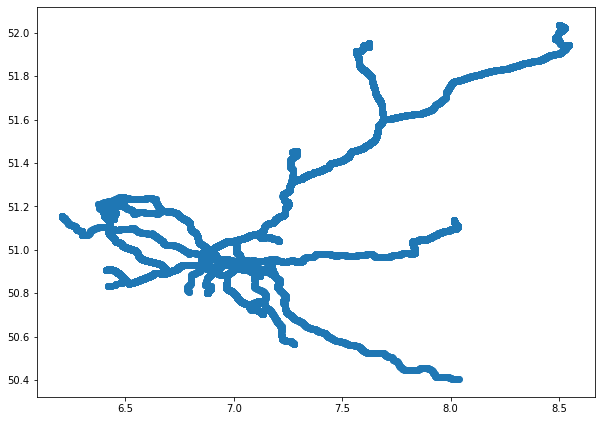

In [32]:
track_df.plot(figsize=(10, 12))

In [53]:
#fixing the speed values
#compare two speed values - GPS Speed.value and Speed.value
track_df['diff']= track_df ['GPS Speed.value']-track_df['Speed.value']
track_df['diff'].describe()

count    36410.000000
mean         1.096880
std          5.723335
min       -255.000008
25%         -0.024620
50%          1.440023
75%          3.084063
max         57.963098
Name: diff, dtype: float64

(array([4.0000e+00, 1.0000e+01, 5.0000e+00, 0.0000e+00, 2.0000e+00,
        6.0000e+00, 4.0000e+00, 9.3900e+02, 3.5437e+04, 3.0000e+00]),
 array([-255.0000076 , -223.70369708, -192.40738655, -161.11107603,
        -129.81476551,  -98.51845498,  -67.22214446,  -35.92583394,
          -4.62952341,   26.66678711,   57.96309763]),
 <a list of 10 Patch objects>)

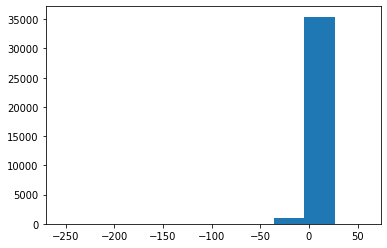

In [54]:
plt.hist(track_df['diff'])

In [ ]:
from pysal import esda
import numpy as np

from pyproj import CRS
from pyproj import Transformer

inputCRS = CRS.from_epsg(4326)
outputCRS = CRS.from_epsg(25832)
transformer = Transformer.from_crs(inputCRS, outputCRS)
def project(a,b):
    return transformer.transform(a, b)


## select stopping times data
df_speed = track_df[track_df['Speed.value'] == 0]

##group by geometry
## as the data is 5 sec if there are repeated lat,lng means the stop is +5 sec
df_speed['lat'] = df_speed['geometry'].apply(lambda coord: coord.y)
df_speed['lng'] = df_speed['geometry'].apply(lambda coord: coord.x)
df_speed['time_sec'] = 5
df_speed.reset_index()


data_speed = df_speed.groupby(['lat','lng'])[['time_sec']].sum().reset_index()
print(data_speed.head())
#change this directory 
#data_speed.to_csv('/home/poshan/Desktop/MSc/FloatingCar/envirocar-py/examples/data.csv')


In [ ]:
data_speed['time_sec'].describe()

In [ ]:
### calculate weights for getis ord
coords = [project(row['lat'], row['lng']) for index, row in data_speed.iterrows()]
w = pysal.weights.DistanceBand(coords, threshold= 50)
w
# coords

In [ ]:
#getisOrdGlobal = esda.getisord.G(data_speed['time_sec'], w)
getisOrdLocal = esda.getisord.G_Local(data_speed['time_sec'], w, transform='B')
getisOrdLocal.Zs

In [ ]:
data_speed['z_score'] = getisOrdLocal.Zs
data_speed['p_value'] = getisOrdLocal.p_norm
# data_speed[data_speed['p_value'] < 0.05]
# data_speed[data_speed['z_score'] == 0]
# data_speed_hotspots = data_speed[data_speed['z_score'] > 0 and data_speed['p_value'] < 0.05]
# hotspots1 = data_speed[data_speed['p_value'] < 0.05]
#query
# hotspot = data_speed.query('z_score > 0 & p_value < 0.05')
#two conditions
hotspot = data_speed[(data_speed.z_score > 0) & (data_speed.p_value <=0.05)]
coldspot = data_speed[(data_speed.z_score < 0) & (data_speed.p_value <=0.05)]

hotspot

In [ ]:
from matplotlib import pyplot as plt
#>1.96 hot spots
#<-1.96 cold spots
from matplotlib import colors as cls

f, axarr = plt.subplots(1, figsize=(10,10))
total_range = cls.Normalize(vmin = - 1.96, vmax = 1.96)

def pltcolor(p_value, z_score, confidence):
    cols=[]
    size=[]
    for p, z in zip(p_value, z_score):
        if p < confidence:
            if z > 0:
                cols.append('red')
                size.append(30)
            else:
                cols.append('blue')
                size.append(30)
        else:
            cols.append('grey')
            size.append(10)
    return cols , size


# Create the colors list using the function above
cols, sizes = pltcolor(data_speed['p_value'], data_speed['z_score'], 0.05)

plt.scatter(x=data_speed['lng'], y=data_speed['lat'], s=sizes, c=cols, lw = 0) #Pass on the list created by the function here
plt.grid(True)
plt.show()

In [ ]:
import folium

lats = data_speed['lat']
lngs = data_speed['lng']

#z-value
z = data_speed['z_score']
p = data_speed['p_value']

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)

m = folium.Map(location=[avg_lat - 0.25, avg_lngs], tiles = 'Stamen Terrain', zoom_start=9)

color, sizes = pltcolor(p, z, 0.05)
time = data_speed['time_sec']
def makepopup(t):
    return str(t) + ' sec'

for lat,lng,c,s,t in zip(lats, lngs, color, sizes, time):
    radius = coords[2]
    folium.CircleMarker([lat,lng], color = c, radius = s, fill = c, popup = makepopup(t)).add_to(m)
m